In [18]:
# importing necessary libraries
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Activation,Conv2D,Dense,MaxPool2D,Dropout,Flatten,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from IPython.display import Image, display
from tensorflow.keras.applications.inception_v3 import InceptionV3
from plot_keras_history import plot_history
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,classification_report
import pandas as pd
import numpy as np
import seaborn as sns

In [15]:
#pip install plot_keras_history

In [3]:
# train and test directory paths
train_dir = '../input/firedata/Training/Training'
test_dir = '../input/firedata/Test/Test'

In [4]:
# ImageDataGenerator to read and augment training data and splitting  20% training data into validation data
train_images = ImageDataGenerator(rescale=1.0/255,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 validation_split=0.2)

training_data = train_images.flow_from_directory(train_dir,
                                                target_size=(254,254), 
                                                color_mode='rgb', 
                                                class_mode='binary',
                                                shuffle=True,
                                                batch_size=64,
                                                subset='training')

validation_data = train_images.flow_from_directory(train_dir, 
                                                    target_size=(254,254),
                                                    color_mode='rgb',
                                                    class_mode='binary',
                                                    batch_size=64,
                                                    shuffle=True,
                                                    subset='validation')

Found 31501 images belonging to 2 classes.
Found 7874 images belonging to 2 classes.


In [5]:
# Loading test data
test_images = ImageDataGenerator(rescale=1.0/255)

test_data = test_images.flow_from_directory(test_dir,
                                            target_size=(254,254), 
                                            color_mode='rgb', 
                                            class_mode='binary',
                                            shuffle=False,
                                            batch_size=1)

Found 8617 images belonging to 2 classes.


In [ ]:
# CNN

In [6]:
# Constructing CNN
input_shape = (254,254,3)
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 252, 252, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 124, 124, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       7

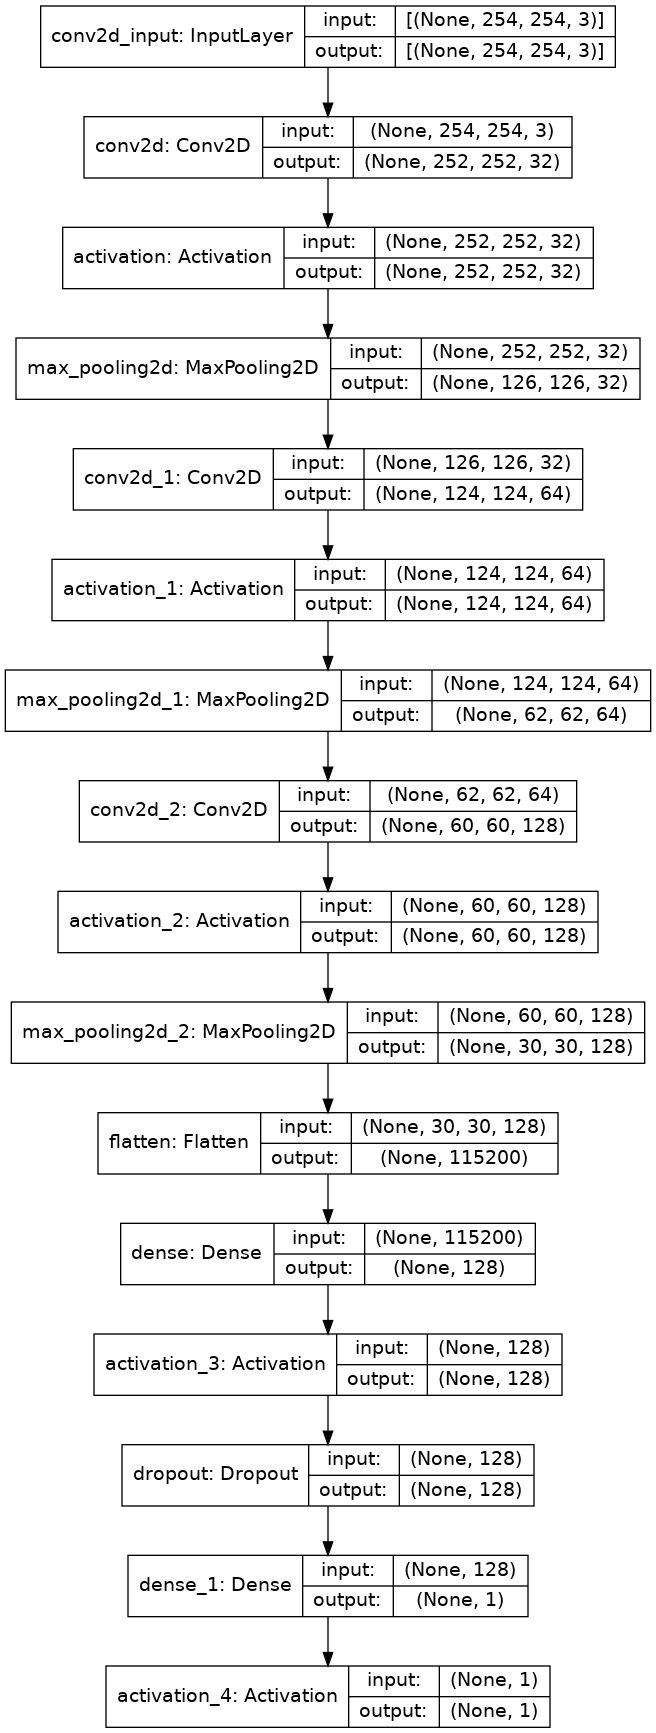

In [7]:
plot_model(model,show_shapes=True, to_file='CNN.png')

In [8]:
# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-10,mode="min",restore_best_weights=True, patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,mode="min", patience=10, verbose=1)
check_point = ModelCheckpoint(filepath='weights.h5', monitor='val_loss',mode="min", verbose=1, save_best_only=True, save_weights_only=False)
tb_log = TensorBoard('logs')
my_callbacks = [early_stop,reduce_lr,check_point,tb_log]

# fitting the training data on model created
history = model.fit(training_data,
                    steps_per_epoch=training_data.samples  // 64,
                    validation_data = validation_data, 
                    validation_steps = validation_data.samples // 64,
                    callbacks=my_callbacks,
                    epochs=20,
                    verbose=1)
model.save('./SimpleConv.h5')

Epoch 1/20
492/492 [==============================] - 842s 2s/step - loss: 0.8200 - accuracy: 0.8287 - val_loss: 0.0955 - val_accuracy: 0.9648

Epoch 00001: val_loss improved from inf to 0.09554, saving model to weights.h5
Epoch 2/20
492/492 [==============================] - 676s 1s/step - loss: 0.1902 - accuracy: 0.9383 - val_loss: 0.0757 - val_accuracy: 0.9726

Epoch 00002: val_loss improved from 0.09554 to 0.07567, saving model to weights.h5
Epoch 3/20
492/492 [==============================] - 687s 1s/step - loss: 0.2577 - accuracy: 0.9434 - val_loss: 0.0956 - val_accuracy: 0.9624

Epoch 00003: val_loss did not improve from 0.07567
Epoch 4/20
492/492 [==============================] - 685s 1s/step - loss: 0.1687 - accuracy: 0.9489 - val_loss: 0.0635 - val_accuracy: 0.9698

Epoch 00004: val_loss improved from 0.07567 to 0.06354, saving model to weights.h5
Epoch 5/20
492/492 [==============================] - 674s 1s/step - loss: 0.2044 - accuracy: 0.9480 - val_loss: 0.0306 - val_ac

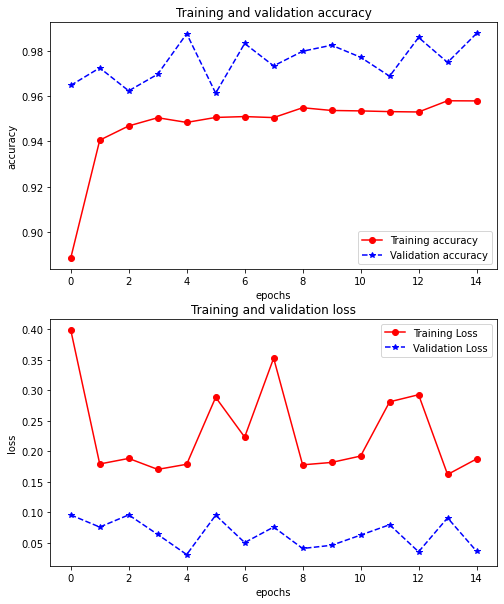

In [19]:
# Plotting loss and accruracy on training data and validation data before finetuning
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(8,10))
plt.subplot(211)
plt.plot(epochs, acc, 'r-o', label='Training accuracy')
plt.plot(epochs, val_acc, 'b--*', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(212)
plt.plot(epochs, loss, 'r-o', label='Training Loss')
plt.plot(epochs, val_loss, 'b--*', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.savefig('CNN1_result.png')

(<Figure size 1080x360 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>,
        <AxesSubplot:title={'center':'Learning rate'}, xlabel='Epochs', ylabel='Learning rate'>],
       dtype=object))

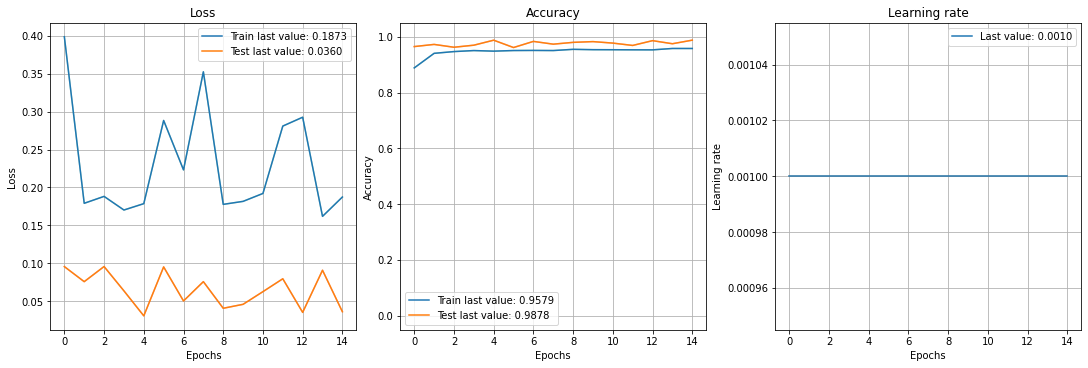

In [22]:
plot_history(history, path="CNN_results.png")

In [10]:
model.evaluate(test_data)

8617/8617 [==============================] - 72s 8ms/step - loss: 2.4651 - accuracy: 0.6613


[2.465132236480713, 0.6612510085105896]

In [27]:
# evaluating the CNN model
test = model.evaluate(test_data)
test_loss , test_acc = test[0],test[1]

valid = model.evaluate(validation_data)
valid_loss,valid_acc =  valid[0],valid[1]

train = model.evaluate(training_data)
train_loss,train_acc = train[0],train[1]


493/493 [==============================] - 525s 1s/step - loss: 0.1122 - accuracy: 0.9522


In [28]:

# creating dataframe with loss and accuracy on train, validation and test sets
pd.DataFrame({'test':{'loss':test_loss,'accuracy':test_acc},
              'validation':{'loss':valid_loss,'accuracy':valid_acc},
              'train':{'loss':train_loss,'accuracy':train_acc}})

,test,validation,train
loss,2.465132,0.035020,0.112158
accuracy,0.661251,0.987173,0.952224


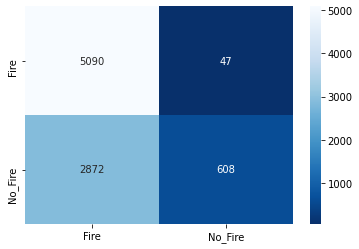

In [29]:
# predictinos on test data
predictions = model.predict(test_data)

# Converting predictions into [0, 1]
pred_list = list(predictions)
predicted_classes = [1 if pred > 0.5 else 0 for pred in pred_list]

# Getting true classes,[0, 1] from test data
true_classes = test_data.classes

# Plotting Confusion Matrix

cm=confusion_matrix(true_classes,predicted_classes)
plot_cm = sns.heatmap(cm,annot=True,
                      fmt='g',cmap='Blues_r',
                      xticklabels=['Fire', 'No_Fire'],
                      yticklabels=['Fire', 'No_Fire'])
#Fire is 0 and No_Fire is 1

plot_cm.figure.savefig("confusion_simpleCNN.png")


In [30]:
print('Classification Report')
print(classification_report(test_data.classes, predicted_classes,target_names=['fire','no_fire']))

Classification Report
              precision    recall  f1-score   support

        fire       0.64      0.99      0.78      5137
     no_fire       0.93      0.17      0.29      3480

    accuracy                           0.66      8617
   macro avg       0.78      0.58      0.54      8617
weighted avg       0.76      0.66      0.58      8617

